# Classification with Dirichlet prior

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

from jax.scipy.special import gammaln

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [3]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


In [184]:
K = 8
N = 1000
sigma = 0.01

alpha = 0.5 * jnp.ones(K,)

In [185]:
key, subkey = random.split(key)
pi = random.dirichlet(subkey, alpha)
print(pi)
print(jnp.sum(pi))

[0.0059662  0.012452   0.15099157 0.00819745 0.31422796 0.05604924
 0.45137008 0.00074548]
0.9999999999999999


In [186]:
#pi = jnp.array([0.68387323, 0.31612677])

In [187]:
key, subkey = random.split(key)
z = random.categorical(subkey, jnp.log(pi), shape = (N,))
print(jnp.sum(z==0)/N)
print(jnp.sum(z==1)/N)

0.003
0.014


In [188]:
key, subkey = random.split(key)
x = random.normal(subkey, shape = (K,))
print(x)
#print(y.shape)

[-1.68081365 -0.84632231 -0.52572157  0.03072467 -1.41259404  0.5589802
  0.50923895 -1.04863258]


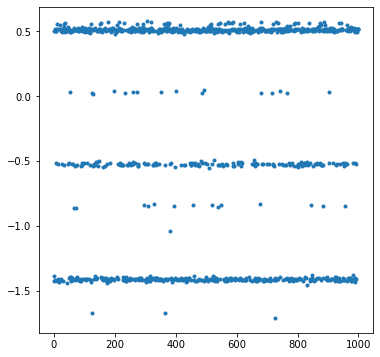

In [189]:
key, subkey = random.split(key)
y = x[z] + sigma * random.normal(subkey, shape = (N,))
plt.plot(y, '.')

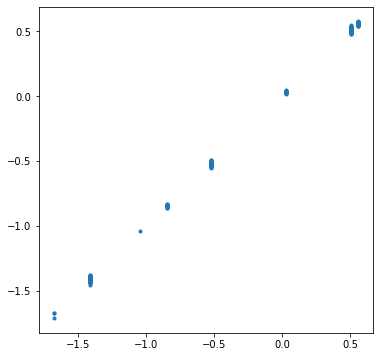

In [190]:
plt.plot(x[z], y, '.')

In [191]:
def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [192]:
calc_nik_jit(z).shape

(1000, 8)

In [193]:
print(calc_nik_ki(z, 0, 13))
print(calc_nik_ki(z, 1, 13))
print(calc_nik_ki(z, 2, 13))

3
14
158


In [195]:
pi

DeviceArray([0.0059662 , 0.012452  , 0.15099157, 0.00819745, 0.31422796,
             0.05604924, 0.45137008, 0.00074548], dtype=float64)

In [196]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

[[0.00348953 0.01445663 0.15802592 ... 0.04835494 0.45214357 0.00149551]
 [0.00348953 0.01445663 0.15802592 ... 0.04835494 0.45214357 0.00149551]
 [0.00348953 0.01445663 0.15802592 ... 0.04835494 0.45114656 0.00149551]
 ...
 [0.00348953 0.01445663 0.15802592 ... 0.04835494 0.45114656 0.00149551]
 [0.00348953 0.01445663 0.15802592 ... 0.04835494 0.45114656 0.00149551]
 [0.00348953 0.01445663 0.15802592 ... 0.04835494 0.45114656 0.00149551]]


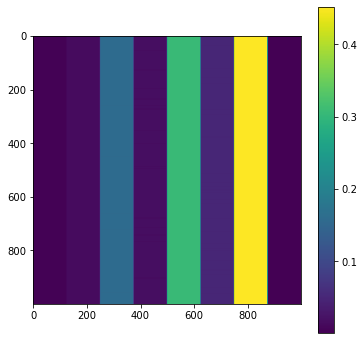

In [197]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
    probs_dn.append((n_ik_z[:, k])/(Nk-1))

probs_d = jnp.array(probs_d).transpose()   
probs_dn = jnp.array(probs_dn).transpose()   

print(probs_d)
#print(jnp.sum(probs_d, axis=1))

plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

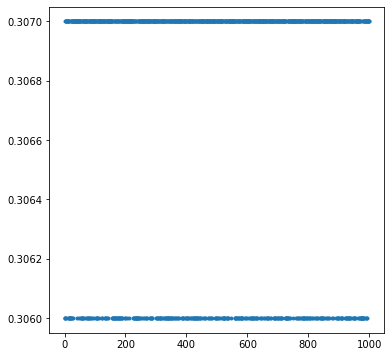

In [199]:
plt.plot(n_ik_z[:,4]/N,'.')

In [206]:
# This log posterior marginalizes over the classes k.
def logPi_marg(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha))

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    # TODO: vectorize
    term_mat = []
    for k in jnp.arange(K):
        logarg_k = jnp.exp(-(y - x[k])**2/sigma) * (n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        log_arg += logarg_k
        term_mat.append(logarg_k)
        #log_arg += jnp.exp(jnp.exp(-(y - x[k])**2/sigma))*pi[k]
        
        logPZalpha += gammaln(n_k[k] + alpha[k])
    
    #print(logPZalpha)
    #print("term A ", jnp.sum(jnp.log(log_arg)) )
    #print("term B ", - jnp.sum(x**2))
    
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) #, jnp.array(term_mat).transpose()
    #return logPZalpha #, jnp.array(term_mat).transpose()

    
# And this does not.
def logPi(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    n_ik_z = jax.vmap(lambda i : n_ik[i, z[i]])(jnp.arange(N))
    
    term1 = jnp.sum(-(y - x[z])**2/sigma)
    term2 = jnp.sum(jnp.log(n_ik_z + alpha[z])) 

    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha)) + jnp.sum(gammaln(n_k + alpha))

    return term1 + term2 - jnp.sum(x**2) + logPZalpha 

In [207]:
print(logPi_marg(jnp.array([x[0], x[1]]), z, y, sigma, alpha))
print(logPi_marg(jnp.array([x[1], x[1]]), z, y, sigma, alpha))
print(logPi_marg(jnp.array([x[0], x[0]]), z, y, sigma, alpha))
print(logPi_marg(jnp.array([x[1], x[0]]), z, y, sigma, alpha))

-99468.78971191283
-105608.09245249642
-270221.1958953286
-101616.48433104459


In [208]:
@jax.jit
def proposal_x_marg(key, x0, logPiX0, B, z, y, sigma, alpha):
    #print("z", z[:10])
    #print("z_correct", z_correct[:10])
    #print(jnp.sum(jnp.abs(z-z_correct)))
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi_marg(x0, z, y, sigma, alpha)
    logPiX1 = logPi_marg(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    #print("z", z[:10])
    #print("z_correct", z_correct[:10])
    #print(jnp.sum(jnp.abs(z-z_correct)))
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0


@jax.jit
def proposal_x0(key, x00, logPiX0, B, x1, z, y, sigma, alpha):
    x01 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x00, x1]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x01, x1]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x01, r, logPiX1, logPiX0    

@jax.jit
def proposal_x1(key, x10, logPiX0, B, x0, z, y, sigma, alpha):
    x11 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x0, x10]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x0, x11]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x11, r, logPiX1, logPiX0    

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    z1 = random.randint(key, z0.shape, 0, K) 

    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

def proposal_z_one(key, z0, logPiX0, x, y, sigma, alpha, K, idx):
    newval = random.randint(key, (), 0, K) 
    z1 = z0.at[idx].set(newval)
   
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0



In [209]:
key, subkey = random.split(key)
_, _, _, _ = proposal_z_one(subkey, z, -1, x, y, sigma, alpha, K, 11)

### First, sample x

In [210]:
print(pi)
print(x)

[0.0059662  0.012452   0.15099157 0.00819745 0.31422796 0.05604924
 0.45137008 0.00074548]
[-1.68081365 -0.84632231 -0.52572157  0.03072467 -1.41259404  0.5589802
  0.50923895 -1.04863258]


In [211]:
z_rand = random.categorical(subkey, jnp.log(pi), shape = (N,))
z_rand = random.randint(subkey, (N,), 0, K)

#### Sampling the marginalized posterior

  MCMC sample 1000, loss = 1737.4743330686551, a = 0.0
  MCMC sample 2000, loss = 1670.6584886703426, a = 0.0
  MCMC sample 3000, loss = 1670.6584886703426, a = 0.0
  MCMC sample 4000, loss = 1670.6584886703426, a = 0.0
  MCMC sample 5000, loss = 1670.6584886703426, a = 0.0
  MCMC sample 6000, loss = 1670.6584886703426, a = 0.0
  MCMC sample 7000, loss = 1670.6584886703426, a = 0.0
  MCMC sample 8000, loss = 1670.6584886703426, a = 0.0
  MCMC sample 9000, loss = 1670.6584886703426, a = 0.0
[-0.48351546 -1.14234764 -0.76453288  0.87036113 -0.4444752  -1.5047174
  2.09669485  0.83045075]
[-1.42930433  0.04465143 -0.5304795   0.43943932 -1.49809579 -2.8903585
  0.56153407  0.11465009]
[-1.68081365 -0.84632231 -0.52572157  0.03072467 -1.41259404  0.5589802
  0.50923895 -1.04863258]


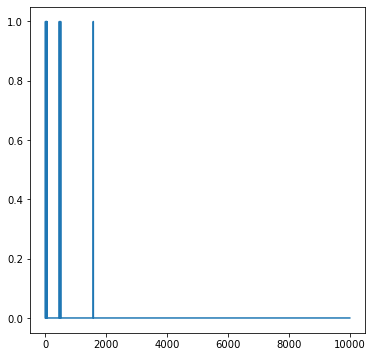

In [212]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x_marg, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


#### And the non-marginalized posterior

  MCMC sample 1000, loss = 11827.53133511863, a = 0.0
  MCMC sample 2000, loss = 9273.158570689226, a = 0.0
  MCMC sample 3000, loss = 9273.158570689226, a = 0.0
  MCMC sample 4000, loss = 9273.158570689226, a = 0.0
  MCMC sample 5000, loss = 9273.158570689226, a = 0.0
  MCMC sample 6000, loss = 9273.158570689226, a = 0.0
  MCMC sample 7000, loss = 9273.158570689226, a = 0.0
  MCMC sample 8000, loss = 9273.158570689226, a = 0.0
  MCMC sample 9000, loss = 9273.158570689226, a = 0.0
[-0.92214078  1.85485796  1.88344912  1.2161744  -1.35785072  0.1299865
 -0.64206012  1.95079198]
[-1.28681348  0.72584723 -0.32199637  1.69978685 -1.2703417  -0.36227872
  0.57115037 -0.74568932]
[-1.68081365 -0.84632231 -0.52572157  0.03072467 -1.41259404  0.5589802
  0.50923895 -1.04863258]


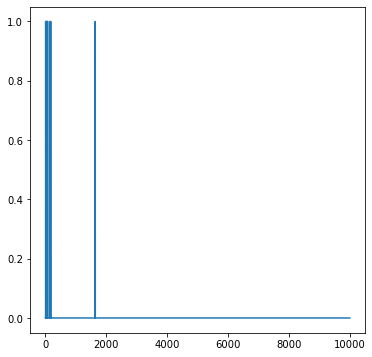

In [213]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


#### And each $x$ at a time

  MCMC sample 1000, loss = 101130.77752018465, a = 7.061835696076768e-205
  MCMC sample 2000, loss = 101132.28760114351, a = 1.3888436811912823e-146
  MCMC sample 3000, loss = 101131.36816444085, a = 0.0
  MCMC sample 4000, loss = 101131.18769796801, a = 6.11363299395787e-113
  MCMC sample 5000, loss = 101130.80940204774, a = 0.0
  MCMC sample 6000, loss = 101131.03760125366, a = 0.0
  MCMC sample 7000, loss = 101130.98066603063, a = 2.0165578026429297e-110
  MCMC sample 8000, loss = 101130.79936035044, a = 0.0
  MCMC sample 9000, loss = 101131.00216454474, a = 0.0
  MCMC sample 10000, loss = 101130.79923971475, a = 0.0
0.08803568773775272
-1.6888745287535878
[-1.68081365 -0.84632231 -0.52572157  0.03072467 -1.41259404  0.5589802
  0.50923895 -1.04863258]


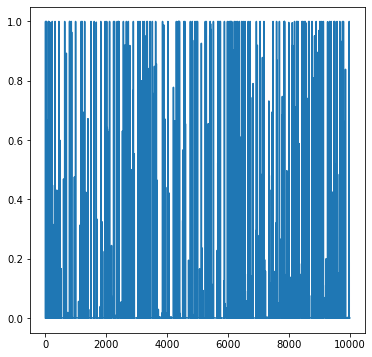

In [214]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x1" : x[1]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x0, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)

print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)

  MCMC sample 1000, loss = 68369.67577979855, a = 0.0
  MCMC sample 2000, loss = 68364.36431706323, a = 1.2048063571669934e-188
  MCMC sample 3000, loss = 68364.36431706323, a = 0.0
  MCMC sample 4000, loss = 68364.36431706323, a = 0.0
  MCMC sample 5000, loss = 68364.36431706323, a = 0.0
  MCMC sample 6000, loss = 68364.36431706323, a = 0.0
  MCMC sample 7000, loss = 68365.4763791598, a = 0.0
  MCMC sample 8000, loss = 68364.94765372499, a = 0.0
  MCMC sample 9000, loss = 68364.94765372499, a = 0.0
  MCMC sample 10000, loss = 68366.70088063597, a = 0.0
0.5423501923190159
-0.26814617840873467
[-1.68081365 -0.84632231 -0.52572157  0.03072467 -1.41259404  0.5589802
  0.50923895 -1.04863258]


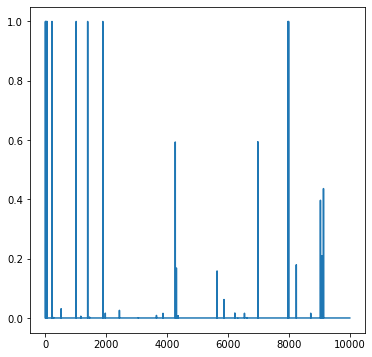

In [215]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x0" : x[0]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x1, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


In [216]:
logPi(x, z, y, sigma, alpha)

DeviceArray(4251.24441905, dtype=float64)

In [217]:
logPi(jnp.array([x[0],x[1]]), z, y, sigma, alpha)

DeviceArray(-101130.77609517, dtype=float64)

In [218]:
logPi(jnp.array([x[1],x[1]]), z, y, sigma, alpha)

DeviceArray(-101340.0139512, dtype=float64)

In [251]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [252]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

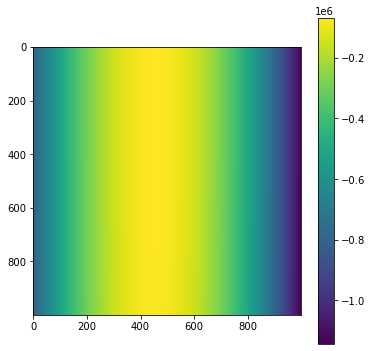

In [253]:
plt.imshow((myf_xy)); plt.colorbar()

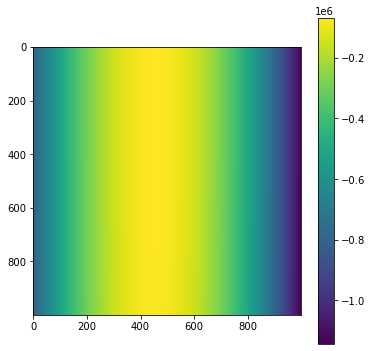

In [254]:
plt.imshow((myf_xy)); plt.colorbar()

In [255]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

01 -101130.77609516573
00 -265953.11739403097
11 -101340.01395119875
10 -266162.35525006405


In [256]:
myf(x[0],x[1])

DeviceArray(-101130.77609517, dtype=float64)

In [257]:
jnp.max(myf_xy)

DeviceArray(-68364.31423939, dtype=float64)

### Now sample z

In [230]:
x

DeviceArray([-1.68081365, -0.84632231, -0.52572157,  0.03072467,
             -1.41259404,  0.5589802 ,  0.50923895, -1.04863258],            dtype=float64)

  MCMC sample 1000, loss = 125786.54452422951, a = 0.0
  MCMC sample 2000, loss = 125786.54452422951, a = 0.0
  MCMC sample 3000, loss = 125786.54452422951, a = 0.0
  MCMC sample 4000, loss = 125786.54452422951, a = 0.0
  MCMC sample 5000, loss = 125786.54452422951, a = 0.0
  MCMC sample 6000, loss = 125786.54452422951, a = 0.0
  MCMC sample 7000, loss = 125786.54452422951, a = 0.0
  MCMC sample 8000, loss = 125786.54452422951, a = 0.0
  MCMC sample 9000, loss = 123991.71973743061, a = 0.0
  MCMC sample 10000, loss = 123991.71973743061, a = 0.0
2.403
2.389


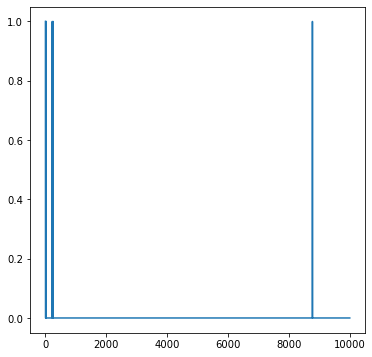

In [232]:
N_samples_z = 10001
z0 = jnp.array(np.random.randint(0, K, (N,)))
#z0 = random.categorical(subkey, jnp.log(pi), shape = (N,))
#z0 = z.at[3].set(1)

#z0 = z0.at[0].set(0)
#z0 = z0.at[1].set(0)
B = 3

#params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : 3}
params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

key, subkey = random.split(key)
z_mean, z_r, z_samples = mcmc(subkey, proposal_z, z0, N_samples_z, params_z, 1, 1)
z_rec = z_samples[N_samples_z-2]
z_rec_m = jnp.mean(z_samples, axis=0)

plt.plot(z_r)
print(jnp.sum(jnp.abs(z0-z))/N)
print(jnp.sum(jnp.abs(z_rec-z))/N)


In [233]:
print(jnp.sum(jnp.abs(z0-z))/N)
print(jnp.sum(jnp.abs(z_rec_m-z))/N)

2.403
2.2355373000000003


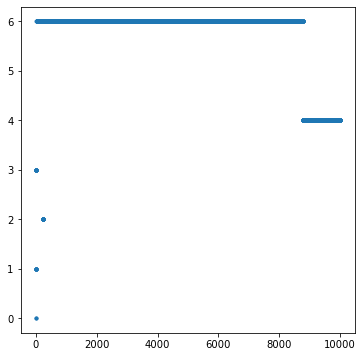

In [237]:
plt.plot(z_samples[:,3], '.')

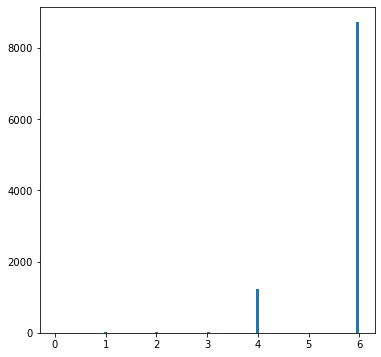

In [241]:
nbins=100
counts, bins = np.histogram(z_samples[:,3], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

To explore next:

* How well does each method estimate the classes $x$ when $z$ is random?
* Is there any situation when the classes would collapse when not using the Dirichlet distribution and using it helps?
* How well can we estimate z and x together?
* What is preferable to use? Marginalized or non-marginalized posterior?